In [3]:
torch.setdefaulttensortype('torch.FloatTensor')

### Load SB dataset

In [4]:
require 'paths'
require 'image'

-- relative = '/home/shrubb/Documents/BKP/Datasets/StanfordBkgd/'
relative = '../Datasets/StanfordBkgd/'
labels = torch.load(relative .. 'labels_th.t7'):add(1):byte()
images = torch.FloatTensor(labels:size(1), 3, 240, 320)

collectgarbage()

filenames = {}
for file in paths.files(relative .. 'images_resized/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

for id, file in ipairs(filenames) do
    images[id]:copy(image.load(relative .. 'images_resized/' .. file))
end

-- labels:apply(function(x) return x == 0 and 2 or x end)

mean = images:mean()
std = images:std()

images:add(-mean)
images:div(std)

collectgarbage()

### Render labels for displaying

In [6]:
function renderLabels(labels, img, blendCoeff)
    local LUT = {
        [0] = {0.0, 0.0, 0.0}, -- void
        [1] = {0.0, 1.0, 1.0}, -- sky
        [2] = {1.0, 1.0, 0.0}, -- tree
        [3] = {0.5, .25, 0.5}, -- road
        [4] = {0.0, 1.0, 0.0}, -- grass
        [5] = {0.0, 0.0, 1.0}, -- water
        [6] = {0.5, 0.0, 0.0}, -- building
        [7] = {1.0, 1.0, 1.0}, -- mountain
        [8] = {1.0, 0.0, 0.0}  -- foreground object
    }
    
    local retval = torch.FloatTensor(3, 240, 320)
    for i = 1,240 do
        for j = 1,320 do
--             if not LUT[labels[{i,j}]] then
--                 print(labels[{i,j}], i, j)
--             end
            for k, color in ipairs(LUT[labels[{i,j}]]) do
                retval[{k,i,j}] = color
            end
        end
    end
    
    if img then
        local labelsBlendCoeff = blendCoeff or 0.62
        retval:mul(labelsBlendCoeff)
        
        img = img:clone()
        img:add(-img:min())
        img:div(img:max())
        img:mul(1 - labelsBlendCoeff)
        retval:add(img)
    end
    
    return retval
end

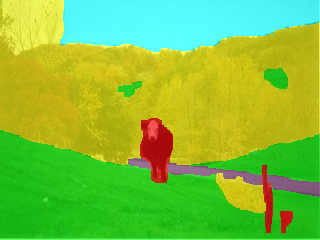

In [7]:
-- example blending
local k = 600
itorch.image(renderLabels(labels[k], images[k]))
-- itorch.image(comparePredictions(images[k], labels[k], predict(net, images[k])))

In [5]:
function jitterScale(img, labelsMat)
    local scaleDiffFactor = math.random() * 0.09 - 0.045 -- originally +/- 10%
    local heightDiff = math.floor(img:size(2) * scaleDiffFactor)
    local widthDiff = math.floor(img:size(3) * scaleDiffFactor)
    local padder = 
        nn.SpatialZeroPadding(widthDiff, widthDiff, heightDiff, heightDiff)

    local imgScaled = image.scale(padder:forward(img), 320, 240, 'bilinear')
    local labelsMatScaled = 
        image.scale(
            padder:forward(labelsMat:view(1, 240, 320)), 320, 240, 'simple')

    return imgScaled, labelsMatScaled:view(240, 320)
end

function jitter(img, labelsMat, flip)
    local imgFlipped, labelsMatFlipped

    if flip then
        imgFlipped = image.flip(img, 3)
        labelsMatFlipped = image.flip(labelsMat, 2)
    end

    local angle = (math.random() - 0.5) * (math.pi / 180 * 9)
    local imgRotated = image.rotate(imgFlipped or img, angle, 'bilinear')
    local labelsMatRotated = 
        image.rotate(labelsMatFlipped or labelsMat, angle, 'simple')

    return jitterScale(imgRotated, labelsMatRotated)
end

In [8]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral-c'] = nil
package.loaded['Integral-c-multi'] = nil
package.loaded['Integral-jit'] = nil
package.loaded['Integral-jit-multi'] = nil
package.loaded['Integral-cuda-multi'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'IntegralSmartNorm'

if CUDA then
    require 'cunn'
end

In [18]:
testDir = 'SB segmentation smartnorm 3layers/'

net = torch.load(testDir .. 'net.t7')
losses = torch.load(testDir .. 'loss-history.t7')
os.execute('mkdir "' .. testDir .. 'Images (test)" -p')

ints = net:findModules('IntegralSmartNorm')
for i = 1,#ints do
    ints[i].maxX = 210
    ints[i].maxY = 540
end

In [138]:
net = nn.Sequential()

convPlusInt = nn.Concat(1)
convPlusInt:add(IntegralSmartNorm(24, 240, 320))
convPlusInt:add(nn.SpatialConvolution(3, 18, 3,3, 1,1, 1,1))
net:add(convPlusInt) -- 3 -> 90

net:add(nn.LeakyReLU(0.03))
net:add(nn.SpatialConvolutionMM(90, 8, 1,1,1,1)) -- 90 -> 8

convPlusInt2 = nn.Concat(1)
convPlusInt2:add(IntegralSmartNorm(20, 240, 320))
convPlusInt2:add(nn.SpatialConvolution(8, 12, 3,3, 1,1, 1,1))
net:add(convPlusInt2) -- 8 -> 172

net:add(nn.LeakyReLU(0.03))
net:add(nn.SpatialConvolution(172, 10, 1,1,1,1)) -- 172 -> 10

convPlusInt3 = nn.Concat(1)
convPlusInt3:add(IntegralSmartNorm(14, 240, 320))
convPlusInt3:add(nn.SpatialConvolution(10, 12, 3,3, 1,1, 1,1))
net:add(convPlusInt3) -- 10 -> 152

net:add(nn.LeakyReLU(0.03))
net:add(nn.SpatialConvolution(152, 8, 1,1,1,1)) -- 152 -> 8

net:add(nn.Reshape(8, 240*320))
net:add(nn.Transpose({2, 1}))

if CUDA then
    require 'cunn'
    net:cuda()
end

In [139]:
params, gradParams = net:parameters()

In [140]:
local function calcClassWeights(labels)
    local counts = {}
    labels:apply(function(x) counts[x] = (counts[x] or 0) + 1 end)
    counts[0] = nil

    local sum = 0
    for k, v in pairs(counts) do
        sum = sum + v
    end

    for k, v in pairs(counts) do
        counts[k] = sum / v -- inverse frequency
    end

    local classWeights = torch.Tensor(counts)
    classWeights:div(classWeights:mean())
    return classWeights
end

criterion = nn.CrossEntropyCriterion(calcClassWeights(labels)):type(net:type())

In [141]:
require 'optim'

datasetIdx = 1

optimStates = {}

for i = 1,#params do
    local lr = 1e-3
    if i <= 4 or (i >= 9 and i <= 12) or (i >= 17 and i <= 20) then
        lr = lr * 200
    end
    
    optimStates[i] = {
        learningRate = lr,
        learningRateDecay = 0.99955
    }
end

In [142]:
package.loaded.WindowDebugger = nil
debug.getregistry().WindowDebugger = nil
WindowDebugger = nil

require 'WindowDebugger'

windowDebugger_1 = WindowDebugger()
windowDebugger_2 = WindowDebugger()
windowDebugger_3 = WindowDebugger()

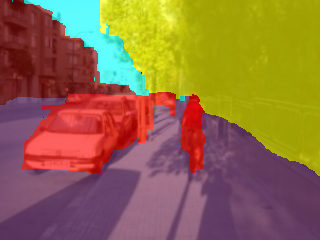

In [100]:
k = 400
img, lab = jitter(images[k], labels[k], true)
itorch.image(renderLabels(lab, img))

In [20]:
require 'gnuplot'

function plotLosses(losses)
    gnuplot.figure(2)
    gnuplot.plot(torch.Tensor(losses), '-')
    gnuplot.axis{1, #losses, 0.4, 2.05}
    gnuplot.xlabel('Iteration')
    gnuplot.ylabel('Loss')
end

In [21]:
plotLosses(losses)

In [144]:
outputDir = 'SB segmentation smartnorm 3layers complex_1/'
os.execute('mkdir "' .. outputDir .. 'Images" -p')

In [145]:
losses = {}

In [12]:
function predict(net, example)
    local pred = net:forward(example:type(net:type()))
    return select(2, pred:view(240, 320, 8):max(3)):squeeze():float()
end

function comparePredictions(img, labels, prediction, omitOriginal)
    img = img:clone():float()
    
    img:add(-img:min())
    img:div(img:max())
    
    local retval
    
    if omitOriginal then
        retval = torch.ones(3, img:size(2), img:size(3)*2 + 2)

        retval[{{}, {}, {1, img:size(3)}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(prediction, img))
    else
        retval = torch.ones(3, img:size(2), img:size(3)*3 + 4)
        retval[{{}, {}, {1, img:size(3)}}]:copy(img)
        retval[{{}, {}, {img:size(3)+3, img:size(3)*2+2}}]:copy(renderLabels(labels, img))
        retval[{{}, {}, {img:size(3)*2+5, retval:size(3)}}]:copy(renderLabels(prediction, img))
    end
    
    return retval
end

In [147]:
evaluationIdx = {
    26,13,58,74,89,98,103,110,132,127,630, -- buildings
    30,21,31,64,71,88,681, -- water/sand
    12,91,678,693, -- mountain
    3,59,82,118,120,698,650 -- grass/trees
}

table.sort(evaluationIdx)

In [148]:
function evaluate(net, images, labels, indices, outPath)
    local losses = {}
    local avgLoss = 0
    
    for k,idx in ipairs(indices) do
        local input = images[idx]:type(net:type())
        local outputs = net:forward(input)
        local target = labels[idx]:clone()
        
        if outPath then
            image.savePNG(
                outPath .. string.format('/%03d.png', idx), 
                comparePredictions(input, target, 
                    select(2, outputs:view(240, 320, 8):max(3)):squeeze():float()))
        end
        
        target = target:view(240*320)

        for i = 1,target:nElement() do
            if target[i] == 0 then
                target[i] = 3
                outputs[i]:zero()
                outputs[{i,3}] = 1e4
            end
        end

        target = target:type(criterion.lsm:type())

        local loss = criterion:forward(outputs, target)
        losses[k] = loss
        avgLoss = avgLoss + loss
    end
    
    collectgarbage()
    
    avgLoss = avgLoss / #indices
    
    return avgLoss, losses
end

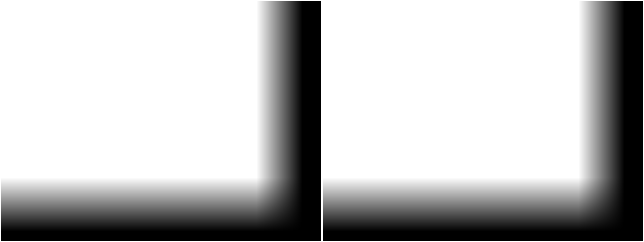

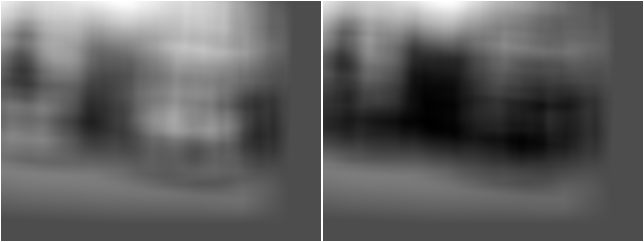

-0.0009765625	0.0009765625	


-976.5625	976.5625	


In [69]:
local k = 6
local int = net:get(1):get(1)

itorch.image{int.outputOnes[k], int.outputOnes[k+24]}
itorch.image{int.outputNonNorm[k], int.outputNonNorm[k+24]}
print(int.outputNonNorm[k][{{1,10}, {310,320}}]:min(), int.outputNonNorm[k+24][{{1,10}, {310,320}}]:max())

itorch.image{int.output[k][{{1,10}, {310,320}}], int.output[k+24][{{1,10}, {310,320}}]}
print(int.output[k][{{1,10}, {310,320}}]:min(), int.output[k+24][{{1,10}, {310,320}}]:max())
-- print(int.outputOnes[k]:eq(1e-6):sum())

In [149]:
batchSize = 10
shuffleEvery = math.ceil(images:size(1) / batchSize) -- shuffle data every `shuffleEvery` iterations
outputFreq = 10 -- how often to output loss to `losses` table and to redraw loss graph
imgOutputFreq = 10 -- save validation predictions as images every `outputFreq*imgOutputFreq` iterations
saveFreq = 50 -- how often to save `net` and `windowDebugger`s

function randomShuffle(t)
  for i = 1,#t do
    local j = math.random(i, #t)
    t[i], t[j] = t[j], t[i]
  end
end

idx = {}
for i = 1,images:size(1) do
    idx[i] = i
end

local avgLoss = 0

for iter = 1,10000 do
    
    if (iter-1) % shuffleEvery == 0 then
        randomShuffle(idx)
        print('Epoch ' .. ((iter-1) / shuffleEvery))
    end
    
    windowDebugger_1:add(net:get(1):get(1))
    windowDebugger_2:add(net:get(4):get(1))
    windowDebugger_3:add(net:get(7):get(1))
    
    local batchLoss = 0 -- at current minibatch
    
    -- forward + backward
    do
        net:zeroGradParameters()

        for k = 1,batchSize do

            local input, target = jitter(
                images[idx[datasetIdx]], 
                labels[idx[datasetIdx]], 
                torch.random() % 2 == 0)
            
            target = target:view(240*320)

            input = input:type(net:type())
            local outputs = net:forward(input)

            for i = 1,target:nElement() do
                if target[i] == 0 then
                    target[i] = 3
                    outputs[i]:zero()
                    outputs[{i,3}] = 1e4
                end
            end
            
            target = target:type(net:type())

            batchLoss = batchLoss + criterion:forward(outputs, target)
            local dLoss_dOutputs = criterion:backward(outputs, target)
            net:backward(input, dLoss_dOutputs, 1/batchSize) -- accumulate gradients
            
            datasetIdx = datasetIdx % labels:size(1) + 1
        end
        
        batchLoss = batchLoss / batchSize
    end
    
    avgLoss = avgLoss + batchLoss
    
    -- optimization step
    for i = 1,#params do
        local feval = function(x)
            return batchLoss, gradParams[i]
        end

        if iter < 13 and i == 1 then
--             print('Param:' .. params[i][1])
--             print('Real param:' .. net:get(1):get(1).xMin[1])
--             print('Grad:' .. gradParams[i][1])
--             print('Real grad:' .. net:get(1):get(1).gradXMin[1])
--             print(torch.data(params[i]), torch.data(net:get(1):get(1).xMin))
        end
        optim.adam(feval, params[i], optimStates[i])
--         if iter < 13 and i == 1 then
--             print(torch.data(params[i]), torch.data(net:get(1):get(1).xMin))
--             print('Params after LR = ' .. optimStates[i].learningRate .. ':')
--             print('Param:' .. params[i][1])
--             print('Real param:' .. net:get(1):get(1).xMin[1])
--             print('')
--         end
    end

    collectgarbage()

    if (iter-1) % outputFreq == 0 then
        losses[#losses+1] = 
            evaluate(net, images, labels, evaluationIdx,
            ((iter-1) % (outputFreq*imgOutputFreq) == 0) and (outputDir .. 'Images/'))
        -- losses[#losses+1] = avgLoss / outputFreq
        
        plotLosses(losses)
    end
    
    if (iter-1) % saveFreq == 0 then
        net:clearState()
        torch.save(outputDir .. 'net.t7', net)
        torch.save(outputDir .. 'loss-history.t7', losses)
        windowDebugger_1:exportVideo(outputDir .. 'int-layer-1.avi')
        windowDebugger_2:exportVideo(outputDir .. 'int-layer-2.avi')
        windowDebugger_3:exportVideo(outputDir .. 'int-layer-3.avi')
    end
    
    if iter % 4 == 0 then
        print(
            'Iteration ' .. iter ..
            ', loss = ' .. (avgLoss / 4 or -1) .. ', ' .. os.date()
        )
        avgLoss = 0
    end
end

Epoch 0	


Iteration 4, loss = 1.9795449882746, Wed Apr 12 23:56:11 2017	


Iteration 8, loss = 2.0006655782461, Wed Apr 12 23:57:03 2017	


Iteration 12, loss = 1.9810265094042, Wed Apr 12 23:58:04 2017	


Iteration 16, loss = 1.9405572474003, Wed Apr 12 23:59:00 2017	


Iteration 20, loss = 1.90025203228, Wed Apr 12 23:59:58 2017	


Iteration 24, loss = 1.8265846431255, Thu Apr 13 00:01:00 2017	


Iteration 28, loss = 1.8080305501819, Thu Apr 13 00:02:01 2017	


Iteration 32, loss = 1.8858147770166, Thu Apr 13 00:03:02 2017	


Iteration 36, loss = 1.8003834575415, Thu Apr 13 00:03:55 2017	


Iteration 40, loss = 1.8241409897804, Thu Apr 13 00:04:53 2017	


Iteration 44, loss = 1.8254707813263, Thu Apr 13 00:05:52 2017	


Iteration 48, loss = 1.6410596311092, Thu Apr 13 00:06:51 2017	


Iteration 52, loss = 1.7261062651873, Thu Apr 13 00:07:56 2017	


Iteration 56, loss = 1.6362443864346, Thu Apr 13 00:08:53 2017	


Iteration 60, loss = 1.7263726621866, Thu Apr 13 00:09:54 2017	


Iteration 64, loss = 1.6379960924387, Thu Apr 13 00:10:53 2017	


Iteration 68, loss = 1.5643831223249, Thu Apr 13 00:11:51 2017	


Iteration 72, loss = 1.6511373579502, Thu Apr 13 00:12:51 2017	
Epoch 1	


Iteration 76, loss = 1.5798491805792, Thu Apr 13 00:13:51 2017	


Iteration 80, loss = 1.6179401546717, Thu Apr 13 00:14:49 2017	


Iteration 84, loss = 1.7305062308908, Thu Apr 13 00:15:54 2017	


Iteration 88, loss = 1.6456188172102, Thu Apr 13 00:16:53 2017	


Iteration 92, loss = 1.6690889954567, Thu Apr 13 00:17:54 2017	


Iteration 96, loss = 1.6810895264149, Thu Apr 13 00:18:54 2017	


Iteration 100, loss = 1.6142146110535, Thu Apr 13 00:19:53 2017	


Iteration 104, loss = 1.5628199785948, Thu Apr 13 00:21:13 2017	


Iteration 108, loss = 1.6576063990593, Thu Apr 13 00:22:13 2017	


Iteration 112, loss = 1.5332815155387, Thu Apr 13 00:23:13 2017	


Iteration 116, loss = 1.6114288434386, Thu Apr 13 00:24:11 2017	


Iteration 120, loss = 1.6279384762049, Thu Apr 13 00:25:09 2017	


Iteration 124, loss = 1.5430036917329, Thu Apr 13 00:26:10 2017	


Iteration 128, loss = 1.603114643693, Thu Apr 13 00:27:10 2017	


Iteration 132, loss = 1.645046967268, Thu Apr 13 00:28:08 2017	


Iteration 136, loss = 1.4233844399452, Thu Apr 13 00:29:05 2017	


Iteration 140, loss = 1.5572734102607, Thu Apr 13 00:30:06 2017	


Iteration 144, loss = 1.5923467755318, Thu Apr 13 00:31:06 2017	
Epoch 2	


Iteration 148, loss = 1.5787726551294, Thu Apr 13 00:32:05 2017	


Iteration 152, loss = 1.6363386571407, Thu Apr 13 00:33:08 2017	


Iteration 156, loss = 1.5273298054934, Thu Apr 13 00:34:05 2017	


Iteration 160, loss = 1.5309312492609, Thu Apr 13 00:35:04 2017	


Iteration 164, loss = 1.4832654207945, Thu Apr 13 00:36:05 2017	


Iteration 168, loss = 1.5390197992325, Thu Apr 13 00:37:03 2017	


Iteration 172, loss = 1.4785963326693, Thu Apr 13 00:38:06 2017	


Iteration 176, loss = 1.6083183780313, Thu Apr 13 00:39:04 2017	


Iteration 180, loss = 1.6621156826615, Thu Apr 13 00:40:01 2017	


Iteration 184, loss = 1.4699882790446, Thu Apr 13 00:41:02 2017	


Iteration 188, loss = 1.4405246168375, Thu Apr 13 00:42:01 2017	


Iteration 192, loss = 1.3806576415896, Thu Apr 13 00:43:03 2017	


Iteration 196, loss = 1.5261278674006, Thu Apr 13 00:44:03 2017	


Iteration 200, loss = 1.474463018775, Thu Apr 13 00:45:01 2017	


Iteration 204, loss = 1.5096769496799, Thu Apr 13 00:46:21 2017	


Iteration 208, loss = 1.5016091942787, Thu Apr 13 00:47:22 2017	


Iteration 212, loss = 1.4511814013124, Thu Apr 13 00:48:19 2017	


Iteration 216, loss = 1.5739578515291, Thu Apr 13 00:49:16 2017	
Epoch 3	


Iteration 220, loss = 1.4697456791997, Thu Apr 13 00:50:13 2017	


Iteration 224, loss = 1.4752638787031, Thu Apr 13 00:51:12 2017	


Iteration 228, loss = 1.4198160424829, Thu Apr 13 00:52:12 2017	


Iteration 232, loss = 1.3741007328033, Thu Apr 13 00:53:13 2017	


Iteration 236, loss = 1.648004360497, Thu Apr 13 00:54:10 2017	


Iteration 240, loss = 1.7064471393824, Thu Apr 13 00:55:10 2017	


Iteration 244, loss = 1.4288348197937, Thu Apr 13 00:56:09 2017	


Iteration 248, loss = 1.4727708607912, Thu Apr 13 00:57:09 2017	


Iteration 252, loss = 1.4665449529886, Thu Apr 13 00:58:11 2017	


Iteration 256, loss = 1.5137161493301, Thu Apr 13 00:59:09 2017	


Iteration 260, loss = 1.3607384368777, Thu Apr 13 01:00:10 2017	


Iteration 264, loss = 1.2838888555765, Thu Apr 13 01:01:11 2017	


Iteration 268, loss = 1.3223103061318, Thu Apr 13 01:02:07 2017	


Iteration 272, loss = 1.3085480749607, Thu Apr 13 01:03:10 2017	


Iteration 276, loss = 1.3872634515166, Thu Apr 13 01:04:07 2017	


Iteration 280, loss = 1.4331928417087, Thu Apr 13 01:05:06 2017	


Iteration 284, loss = 1.4997717097402, Thu Apr 13 01:06:08 2017	


Iteration 288, loss = 1.4709770336747, Thu Apr 13 01:07:06 2017	
Epoch 4	


Iteration 292, loss = 1.4128157377243, Thu Apr 13 01:08:09 2017	


Iteration 296, loss = 1.4815362811089, Thu Apr 13 01:09:06 2017	


Iteration 300, loss = 1.3129342406988, Thu Apr 13 01:10:04 2017	


Iteration 304, loss = 1.4173405706882, Thu Apr 13 01:11:27 2017	


Iteration 308, loss = 1.3977519325912, Thu Apr 13 01:12:25 2017	


Iteration 312, loss = 1.2769312083721, Thu Apr 13 01:13:27 2017	


Iteration 316, loss = 1.4453195691109, Thu Apr 13 01:14:26 2017	


Iteration 320, loss = 1.410119933635, Thu Apr 13 01:15:24 2017	


Iteration 324, loss = 1.3381350137293, Thu Apr 13 01:16:23 2017	


Iteration 328, loss = 1.3697591096163, Thu Apr 13 01:17:23 2017	


Iteration 332, loss = 1.2510554738343, Thu Apr 13 01:18:25 2017	


Iteration 336, loss = 1.2488080665469, Thu Apr 13 01:19:24 2017	


Iteration 340, loss = 1.2686088725924, Thu Apr 13 01:20:24 2017	


Iteration 344, loss = 1.3468791052699, Thu Apr 13 01:21:24 2017	


Iteration 348, loss = 1.265579071641, Thu Apr 13 01:22:24 2017	


Iteration 352, loss = 1.2996406525373, Thu Apr 13 01:23:29 2017	


Iteration 356, loss = 1.3874388322234, Thu Apr 13 01:24:26 2017	


Iteration 360, loss = 1.3644229635596, Thu Apr 13 01:25:22 2017	
Epoch 5	


Iteration 364, loss = 1.2276320382953, Thu Apr 13 01:26:24 2017	


Iteration 368, loss = 1.4461105972528, Thu Apr 13 01:27:22 2017	


Iteration 372, loss = 1.2378977507353, Thu Apr 13 01:28:22 2017	


Iteration 376, loss = 1.349088922888, Thu Apr 13 01:29:22 2017	


Iteration 380, loss = 1.3340786986053, Thu Apr 13 01:30:19 2017	


Iteration 384, loss = 1.3871022164822, Thu Apr 13 01:31:20 2017	


Iteration 388, loss = 1.339723688364, Thu Apr 13 01:32:19 2017	


Iteration 392, loss = 1.33234115839, Thu Apr 13 01:33:18 2017	


Iteration 396, loss = 1.3414700716734, Thu Apr 13 01:34:18 2017	


Iteration 400, loss = 1.3230486556888, Thu Apr 13 01:35:16 2017	


Iteration 404, loss = 1.3050813674927, Thu Apr 13 01:36:39 2017	


Iteration 408, loss = 1.1821111030877, Thu Apr 13 01:37:38 2017	


Iteration 412, loss = 1.1906964629889, Thu Apr 13 01:38:40 2017	


Iteration 416, loss = 1.2429011568427, Thu Apr 13 01:39:39 2017	


Iteration 420, loss = 1.3688656136394, Thu Apr 13 01:40:39 2017	


Iteration 424, loss = 1.2453364983201, Thu Apr 13 01:41:38 2017	


Iteration 428, loss = 1.1035492181778, Thu Apr 13 01:42:35 2017	


Iteration 432, loss = 1.1395863547921, Thu Apr 13 01:43:38 2017	
Epoch 6	


Iteration 436, loss = 1.3526434063911, Thu Apr 13 01:44:34 2017	


Iteration 440, loss = 1.3583487868309, Thu Apr 13 01:45:34 2017	


Iteration 444, loss = 1.1684689342976, Thu Apr 13 01:46:35 2017	


Iteration 448, loss = 1.3121966414154, Thu Apr 13 01:47:34 2017	


Iteration 452, loss = 1.2848051942885, Thu Apr 13 01:48:38 2017	


Iteration 456, loss = 1.2620908766985, Thu Apr 13 01:49:36 2017	


Iteration 460, loss = 1.2286672145128, Thu Apr 13 01:50:34 2017	


Iteration 464, loss = 1.2656604319811, Thu Apr 13 01:51:37 2017	


Iteration 468, loss = 1.183115939796, Thu Apr 13 01:52:35 2017	


Iteration 472, loss = 1.1519593387842, Thu Apr 13 01:53:35 2017	


Iteration 476, loss = 1.3351228222251, Thu Apr 13 01:54:36 2017	


Iteration 480, loss = 1.2704358205199, Thu Apr 13 01:55:32 2017	


Iteration 484, loss = 1.1256773412228, Thu Apr 13 01:56:34 2017	


Iteration 488, loss = 1.1460009023547, Thu Apr 13 01:57:32 2017	


Iteration 492, loss = 1.1580778211355, Thu Apr 13 01:58:34 2017	


Iteration 496, loss = 1.2179381206632, Thu Apr 13 01:59:35 2017	


Iteration 500, loss = 1.1281372115016, Thu Apr 13 02:00:31 2017	


Iteration 504, loss = 1.256475122273, Thu Apr 13 02:01:53 2017	
Epoch 7	


Iteration 508, loss = 1.0662685990334, Thu Apr 13 02:02:53 2017	


Iteration 512, loss = 1.1257262453437, Thu Apr 13 02:03:53 2017	


Iteration 516, loss = 1.2222608797252, Thu Apr 13 02:04:50 2017	


Iteration 520, loss = 1.1076940327883, Thu Apr 13 02:05:49 2017	


Iteration 524, loss = 1.1891528628767, Thu Apr 13 02:06:47 2017	


Iteration 528, loss = 1.3582876756787, Thu Apr 13 02:07:45 2017	


Iteration 532, loss = 1.1368393339217, Thu Apr 13 02:08:47 2017	


Iteration 536, loss = 1.0849306426942, Thu Apr 13 02:09:45 2017	

Iteration 540, loss = 1.1316415265203, Thu Apr 13 02:10:46 2017	


Iteration 544, loss = 1.0908511281013, Thu Apr 13 02:11:45 2017	


Iteration 548, loss = 1.2581306770444, Thu Apr 13 02:12:43 2017	


Iteration 552, loss = 1.2081618860364, Thu Apr 13 02:13:51 2017	


Iteration 556, loss = 1.1815869376063, Thu Apr 13 02:14:49 2017	


Iteration 560, loss = 1.3267944663763, Thu Apr 13 02:15:48 2017	


Iteration 564, loss = 1.1859621807933, Thu Apr 13 02:16:51 2017	


Iteration 568, loss = 1.2071006245911, Thu Apr 13 02:17:49 2017	


Iteration 572, loss = 1.3513782799244, Thu Apr 13 02:18:52 2017	


Iteration 576, loss = 1.293883703649, Thu Apr 13 02:19:52 2017	
Epoch 8	


Iteration 580, loss = 1.1831798814237, Thu Apr 13 02:20:50 2017	


Iteration 584, loss = 1.1162344232202, Thu Apr 13 02:21:52 2017	


Iteration 588, loss = 1.2436651572585, Thu Apr 13 02:22:50 2017	


Iteration 592, loss = 1.2395929425955, Thu Apr 13 02:23:50 2017	


Iteration 596, loss = 1.0806281328201, Thu Apr 13 02:24:51 2017	


Iteration 600, loss = 1.160977755487, Thu Apr 13 02:25:51 2017	


Iteration 604, loss = 1.2270987227559, Thu Apr 13 02:27:14 2017	


Iteration 608, loss = 1.2218494862318, Thu Apr 13 02:28:13 2017	


Iteration 612, loss = 1.1085878685117, Thu Apr 13 02:29:14 2017	


Iteration 616, loss = 1.1526909708977, Thu Apr 13 02:30:11 2017	


Iteration 620, loss = 1.16391736269, Thu Apr 13 02:31:10 2017	


Iteration 624, loss = 1.3274084553123, Thu Apr 13 02:32:09 2017	


Iteration 628, loss = 1.0353884547949, Thu Apr 13 02:33:09 2017	


Iteration 632, loss = 1.1237360745668, Thu Apr 13 02:34:10 2017	


Iteration 636, loss = 1.1116194866598, Thu Apr 13 02:35:08 2017	


Iteration 640, loss = 1.1975756943226, Thu Apr 13 02:36:08 2017	


Iteration 644, loss = 1.115306687355, Thu Apr 13 02:37:09 2017	


Iteration 648, loss = 1.1650046057999, Thu Apr 13 02:38:08 2017	
Epoch 9	


Iteration 652, loss = 1.1838720843196, Thu Apr 13 02:39:16 2017	


Iteration 656, loss = 1.1246732339263, Thu Apr 13 02:40:15 2017	


Iteration 660, loss = 1.1352971494198, Thu Apr 13 02:41:14 2017	


Iteration 664, loss = 1.1124939620495, Thu Apr 13 02:42:08 2017	


Iteration 668, loss = 1.0123248048127, Thu Apr 13 02:43:09 2017	


Iteration 672, loss = 1.3414798684418, Thu Apr 13 02:44:08 2017	


Iteration 676, loss = 1.2785344965756, Thu Apr 13 02:45:08 2017	


Iteration 680, loss = 1.2023093089461, Thu Apr 13 02:46:08 2017	


Iteration 684, loss = 1.246931001544, Thu Apr 13 02:47:08 2017	


Iteration 688, loss = 1.12285015136, Thu Apr 13 02:48:08 2017	


Iteration 692, loss = 1.103594020009, Thu Apr 13 02:49:06 2017	


Iteration 696, loss = 1.0820796906948, Thu Apr 13 02:50:04 2017	


Iteration 700, loss = 1.0655078530312, Thu Apr 13 02:51:02 2017	


Iteration 704, loss = 1.2792024120688, Thu Apr 13 02:52:28 2017	


Iteration 708, loss = 1.2261291332543, Thu Apr 13 02:53:26 2017	


Iteration 712, loss = 1.0813416145742, Thu Apr 13 02:54:28 2017	


Iteration 716, loss = 1.2546822160482, Thu Apr 13 02:55:26 2017	


Iteration 720, loss = 1.2727686718106, Thu Apr 13 02:56:25 2017	
Epoch 10	


Iteration 724, loss = 1.1692992396653, Thu Apr 13 02:57:25 2017	


Iteration 728, loss = 1.0795804478228, Thu Apr 13 02:58:23 2017	


Iteration 732, loss = 1.1574450738728, Thu Apr 13 02:59:25 2017	


Iteration 736, loss = 1.1442750550807, Thu Apr 13 03:00:21 2017	


Iteration 740, loss = 1.1873071715236, Thu Apr 13 03:01:21 2017	


Iteration 744, loss = 1.1527231946588, Thu Apr 13 03:02:23 2017	


Iteration 748, loss = 1.0785855531693, Thu Apr 13 03:03:18 2017	


Iteration 752, loss = 1.2337100341916, Thu Apr 13 03:04:25 2017	


Iteration 756, loss = 1.0271107062697, Thu Apr 13 03:05:24 2017	


Iteration 760, loss = 1.2982331261039, Thu Apr 13 03:06:24 2017	


Iteration 764, loss = 1.1048662543297, Thu Apr 13 03:07:26 2017	


Iteration 768, loss = 1.1488697767258, Thu Apr 13 03:08:24 2017	


Iteration 772, loss = 1.1036053366959, Thu Apr 13 03:09:25 2017	


Iteration 776, loss = 1.1431228503585, Thu Apr 13 03:10:24 2017	


Iteration 780, loss = 1.1192548774183, Thu Apr 13 03:11:23 2017	


Iteration 784, loss = 1.0745639920235, Thu Apr 13 03:12:23 2017	


Iteration 788, loss = 1.0972250550985, Thu Apr 13 03:13:22 2017	


Iteration 792, loss = 1.2575017780066, Thu Apr 13 03:14:23 2017	
Epoch 11	


Iteration 796, loss = 1.1906868897378, Thu Apr 13 03:15:22 2017	


Iteration 800, loss = 1.1734352990985, Thu Apr 13 03:16:19 2017	


Iteration 804, loss = 1.1195662118495, Thu Apr 13 03:17:46 2017	


Iteration 808, loss = 1.2370287723839, Thu Apr 13 03:18:47 2017	


Iteration 812, loss = 1.1331818006933, Thu Apr 13 03:19:49 2017	


Iteration 816, loss = 1.181223218143, Thu Apr 13 03:20:43 2017	


Iteration 820, loss = 1.0674012929201, Thu Apr 13 03:21:43 2017	


Iteration 824, loss = 1.1521774351597, Thu Apr 13 03:22:42 2017	


Iteration 828, loss = 1.0525991648436, Thu Apr 13 03:23:39 2017	


Iteration 832, loss = 1.0428978778422, Thu Apr 13 03:24:41 2017	


Iteration 836, loss = 1.0356540441513, Thu Apr 13 03:25:39 2017	


Iteration 840, loss = 1.109885391593, Thu Apr 13 03:26:38 2017	


Iteration 844, loss = 1.2896151840687, Thu Apr 13 03:27:40 2017	


Iteration 848, loss = 1.1175701372325, Thu Apr 13 03:28:38 2017	


Iteration 852, loss = 1.189300005883, Thu Apr 13 03:29:48 2017	


Iteration 856, loss = 1.1625894606113, Thu Apr 13 03:30:48 2017	


Iteration 860, loss = 1.1341958090663, Thu Apr 13 03:31:45 2017	


Iteration 864, loss = 1.1190912082791, Thu Apr 13 03:32:47 2017	
Epoch 12	


Iteration 868, loss = 1.1125558078289, Thu Apr 13 03:33:43 2017	


Iteration 872, loss = 1.1115696415305, Thu Apr 13 03:34:45 2017	


Iteration 876, loss = 1.1203290179372, Thu Apr 13 03:35:42 2017	


Iteration 880, loss = 1.0032094165683, Thu Apr 13 03:36:39 2017	


Iteration 884, loss = 1.1147080004215, Thu Apr 13 03:37:41 2017	


Iteration 888, loss = 1.205319712311, Thu Apr 13 03:38:38 2017	


Iteration 892, loss = 1.1111515134573, Thu Apr 13 03:39:40 2017	


Iteration 896, loss = 1.1068472065032, Thu Apr 13 03:40:41 2017	


Iteration 900, loss = 1.051393841207, Thu Apr 13 03:41:38 2017	


Iteration 904, loss = 1.1506254434586, Thu Apr 13 03:43:04 2017	


Iteration 908, loss = 1.1769984483719, Thu Apr 13 03:44:04 2017	


Iteration 912, loss = 1.0657785475254, Thu Apr 13 03:45:07 2017	


Iteration 916, loss = 1.1151832990348, Thu Apr 13 03:46:05 2017	


Iteration 920, loss = 1.1391710080206, Thu Apr 13 03:47:05 2017	


Iteration 924, loss = 1.2208118394017, Thu Apr 13 03:48:03 2017	


Iteration 928, loss = 1.1920128837228, Thu Apr 13 03:49:01 2017	


Iteration 932, loss = 1.1545619517565, Thu Apr 13 03:50:02 2017	


Iteration 936, loss = 1.0964881442487, Thu Apr 13 03:50:59 2017	
Epoch 13	


Iteration 940, loss = 1.1305671744049, Thu Apr 13 03:52:00 2017	


Iteration 944, loss = 1.1479793183506, Thu Apr 13 03:52:58 2017	


Iteration 948, loss = 1.0879077255726, Thu Apr 13 03:54:00 2017	


Iteration 952, loss = 1.2613253191113, Thu Apr 13 03:55:10 2017	


Iteration 956, loss = 1.089549767971, Thu Apr 13 03:56:09 2017	


Iteration 960, loss = 1.1659415185452, Thu Apr 13 03:57:09 2017	


Iteration 964, loss = 1.0209355138242, Thu Apr 13 03:58:07 2017	


Iteration 968, loss = 1.080821762234, Thu Apr 13 03:59:05 2017	


Iteration 972, loss = 1.1258675642312, Thu Apr 13 04:00:02 2017	


Iteration 976, loss = 1.0703417293727, Thu Apr 13 04:01:03 2017	


Iteration 980, loss = 1.0129050001502, Thu Apr 13 04:02:01 2017	


Iteration 984, loss = 0.97065075561404, Thu Apr 13 04:03:00 2017	


Iteration 988, loss = 1.0639424309134, Thu Apr 13 04:04:00 2017	


Iteration 992, loss = 1.1111021406949, Thu Apr 13 04:05:00 2017	


Iteration 996, loss = 1.1943421855569, Thu Apr 13 04:05:59 2017	


Iteration 1000, loss = 1.199492457509, Thu Apr 13 04:06:56 2017	


Iteration 1004, loss = 1.1374693058431, Thu Apr 13 04:08:25 2017	


Iteration 1008, loss = 1.2026303514838, Thu Apr 13 04:09:22 2017	
Epoch 14	


Iteration 1012, loss = 1.1606719143689, Thu Apr 13 04:10:24 2017	


Iteration 1016, loss = 1.0719151057303, Thu Apr 13 04:11:22 2017	


Iteration 1020, loss = 1.0208091244102, Thu Apr 13 04:12:22 2017	


Iteration 1024, loss = 1.1584814526141, Thu Apr 13 04:13:20 2017	


Iteration 1028, loss = 1.0371402621269, Thu Apr 13 04:14:18 2017	


Iteration 1032, loss = 1.0888727560639, Thu Apr 13 04:15:21 2017	


Iteration 1036, loss = 1.1005530267954, Thu Apr 13 04:16:19 2017	


Iteration 1040, loss = 1.0474357619882, Thu Apr 13 04:17:18 2017	


Iteration 1044, loss = 1.0612632103264, Thu Apr 13 04:18:20 2017	


Iteration 1048, loss = 1.1396225303411, Thu Apr 13 04:19:17 2017	


Iteration 1052, loss = 1.1151013955474, Thu Apr 13 04:20:30 2017	


Iteration 1056, loss = 1.0805086374283, Thu Apr 13 04:21:28 2017	


Iteration 1060, loss = 1.1811408832669, Thu Apr 13 04:22:26 2017	


Iteration 1064, loss = 1.17698802948, Thu Apr 13 04:23:28 2017	


Iteration 1068, loss = 1.0967533551157, Thu Apr 13 04:24:26 2017	


Iteration 1072, loss = 1.1271069422364, Thu Apr 13 04:25:26 2017	


Iteration 1076, loss = 1.1951857045293, Thu Apr 13 04:26:26 2017	


Iteration 1080, loss = 0.97867904603481, Thu Apr 13 04:27:23 2017	
Epoch 15	


Iteration 1084, loss = 1.0864496037364, Thu Apr 13 04:28:24 2017	


Iteration 1088, loss = 1.0864828854799, Thu Apr 13 04:29:21 2017	


Iteration 1092, loss = 1.1059187851846, Thu Apr 13 04:30:24 2017	


Iteration 1096, loss = 1.0944080933928, Thu Apr 13 04:31:23 2017	


Iteration 1100, loss = 1.1449998438358, Thu Apr 13 04:32:21 2017	


Iteration 1104, loss = 1.1030653730035, Thu Apr 13 04:33:46 2017	


Iteration 1108, loss = 1.0652822166681, Thu Apr 13 04:34:46 2017	


Iteration 1112, loss = 1.0941220402718, Thu Apr 13 04:35:46 2017	


Iteration 1116, loss = 1.0976242475212, Thu Apr 13 04:36:41 2017	


Iteration 1120, loss = 0.9963611535728, Thu Apr 13 04:37:41 2017	


Iteration 1124, loss = 1.0064293272793, Thu Apr 13 04:38:39 2017	


Iteration 1128, loss = 1.2018267065287, Thu Apr 13 04:39:39 2017	


Iteration 1132, loss = 1.1469388335943, Thu Apr 13 04:40:39 2017	


Iteration 1136, loss = 1.0982918106019, Thu Apr 13 04:41:34 2017	


Iteration 1140, loss = 1.130488589406, Thu Apr 13 04:42:34 2017	


Iteration 1144, loss = 0.93269900605083, Thu Apr 13 04:43:35 2017	


Iteration 1148, loss = 1.210714173317, Thu Apr 13 04:44:35 2017	


Iteration 1152, loss = 1.2260730460286, Thu Apr 13 04:45:46 2017	
Epoch 16	


Iteration 1156, loss = 1.2646401226521, Thu Apr 13 04:46:44 2017	


Iteration 1160, loss = 1.2198724165559, Thu Apr 13 04:47:43 2017	


Iteration 1164, loss = 1.0974657997489, Thu Apr 13 04:48:43 2017	


Iteration 1168, loss = 1.0854725182056, Thu Apr 13 04:49:42 2017	


Iteration 1172, loss = 1.1283651910722, Thu Apr 13 04:50:44 2017	


Iteration 1176, loss = 1.1246880784631, Thu Apr 13 04:51:41 2017	


Iteration 1180, loss = 1.0185038387775, Thu Apr 13 04:52:40 2017	


Iteration 1184, loss = 1.1010260164738, Thu Apr 13 04:53:41 2017	


Iteration 1188, loss = 1.0448326840997, Thu Apr 13 04:54:38 2017	


Iteration 1192, loss = 1.0831847004592, Thu Apr 13 04:55:40 2017	


Iteration 1196, loss = 1.043674172461, Thu Apr 13 04:56:38 2017	


Iteration 1200, loss = 1.0827657088637, Thu Apr 13 04:57:35 2017	


Iteration 1204, loss = 1.0024952478707, Thu Apr 13 04:59:06 2017	


Iteration 1208, loss = 1.1124133892357, Thu Apr 13 05:00:03 2017	


Iteration 1212, loss = 1.0118740208447, Thu Apr 13 05:01:03 2017	


Iteration 1216, loss = 1.0792600296438, Thu Apr 13 05:02:06 2017	


Iteration 1220, loss = 1.1605036467314, Thu Apr 13 05:03:03 2017	


Iteration 1224, loss = 1.0810379400849, Thu Apr 13 05:04:04 2017	
Epoch 17	


Iteration 1228, loss = 1.1141836121678, Thu Apr 13 05:05:01 2017	


Iteration 1232, loss = 1.0686352409422, Thu Apr 13 05:06:02 2017	


Iteration 1236, loss = 1.0374919816852, Thu Apr 13 05:07:02 2017	


Iteration 1240, loss = 1.0405655995011, Thu Apr 13 05:07:59 2017	


Iteration 1244, loss = 1.0860083296895, Thu Apr 13 05:08:59 2017	


Iteration 1248, loss = 1.2338993407786, Thu Apr 13 05:09:57 2017	


Iteration 1252, loss = 1.0886676214635, Thu Apr 13 05:11:07 2017	


Iteration 1256, loss = 0.98019871637225, Thu Apr 13 05:12:08 2017	


Iteration 1260, loss = 1.142749607563, Thu Apr 13 05:13:06 2017	


Iteration 1264, loss = 1.2503306277096, Thu Apr 13 05:14:04 2017	


Iteration 1268, loss = 1.0977764129639, Thu Apr 13 05:15:03 2017	


Iteration 1272, loss = 1.059350644052, Thu Apr 13 05:16:04 2017	


Iteration 1276, loss = 1.0531153708696, Thu Apr 13 05:17:02 2017	


Iteration 1280, loss = 1.0190250210464, Thu Apr 13 05:17:53 2017	


Iteration 1284, loss = 1.0587375804782, Thu Apr 13 05:18:54 2017	


Iteration 1288, loss = 1.0222360685468, Thu Apr 13 05:19:50 2017	


Iteration 1292, loss = 1.0629530623555, Thu Apr 13 05:20:51 2017	


Iteration 1296, loss = 1.0746608145535, Thu Apr 13 05:21:48 2017	
Epoch 18	


Iteration 1300, loss = 0.97400581538677, Thu Apr 13 05:22:46 2017	


Iteration 1304, loss = 0.99090924710035, Thu Apr 13 05:24:15 2017	


Iteration 1308, loss = 1.1103533983231, Thu Apr 13 05:25:14 2017	


Iteration 1312, loss = 1.0554368853569, Thu Apr 13 05:26:15 2017	


Iteration 1316, loss = 1.1507058098912, Thu Apr 13 05:27:15 2017	


Iteration 1320, loss = 1.0026029519737, Thu Apr 13 05:28:14 2017	


Iteration 1324, loss = 1.0515871681273, Thu Apr 13 05:29:12 2017	


Iteration 1328, loss = 0.89379707425833, Thu Apr 13 05:30:12 2017	


Iteration 1332, loss = 1.1040157355368, Thu Apr 13 05:31:12 2017	


Iteration 1336, loss = 0.93188545703888, Thu Apr 13 05:32:12 2017	


Iteration 1340, loss = 1.033059707284, Thu Apr 13 05:33:10 2017	


Iteration 1344, loss = 1.0648567564785, Thu Apr 13 05:34:11 2017	


Iteration 1348, loss = 1.2525768905878, Thu Apr 13 05:35:11 2017	


Iteration 1352, loss = 1.09961681813, Thu Apr 13 05:36:32 2017	


Iteration 1356, loss = 1.0535018488765, Thu Apr 13 05:37:31 2017	


Iteration 1360, loss = 1.1639107614756, Thu Apr 13 05:38:30 2017	


Iteration 1364, loss = 1.0874921321869, Thu Apr 13 05:39:30 2017	


Iteration 1368, loss = 1.1064406350255, Thu Apr 13 05:40:28 2017	
Epoch 19	


Iteration 1372, loss = 1.0886350572109, Thu Apr 13 05:41:29 2017	


Iteration 1376, loss = 1.0748857632279, Thu Apr 13 05:42:23 2017	


Iteration 1380, loss = 0.89120658412576, Thu Apr 13 05:43:25 2017	


Iteration 1384, loss = 1.0907253861427, Thu Apr 13 05:44:23 2017	


Iteration 1388, loss = 0.98909827470779, Thu Apr 13 05:45:22 2017	


Iteration 1392, loss = 1.0752494759858, Thu Apr 13 05:46:24 2017	


Iteration 1396, loss = 0.95568818449974, Thu Apr 13 05:47:20 2017	


Iteration 1400, loss = 1.0621476523578, Thu Apr 13 05:48:20 2017	


Iteration 1404, loss = 1.2002961575985, Thu Apr 13 05:49:53 2017	


Iteration 1408, loss = 1.0560509525239, Thu Apr 13 05:50:51 2017	


Iteration 1412, loss = 1.0245063476264, Thu Apr 13 05:51:50 2017	


Iteration 1416, loss = 1.0304283477366, Thu Apr 13 05:52:50 2017	


Iteration 1420, loss = 1.0695010244846, Thu Apr 13 05:53:46 2017	


Iteration 1424, loss = 1.0475330278277, Thu Apr 13 05:54:48 2017	


Iteration 1428, loss = 1.0888175293803, Thu Apr 13 05:55:45 2017	


Iteration 1432, loss = 1.1008440554142, Thu Apr 13 05:56:47 2017	


Iteration 1436, loss = 1.2329947143793, Thu Apr 13 05:57:45 2017	


Iteration 1440, loss = 0.98922613561153, Thu Apr 13 05:58:42 2017	
Epoch 20	


Iteration 1444, loss = 1.0707384705544, Thu Apr 13 05:59:44 2017	


Iteration 1448, loss = 1.0494983904064, Thu Apr 13 06:00:41 2017	


Iteration 1452, loss = 1.0759116388857, Thu Apr 13 06:01:56 2017	


Iteration 1456, loss = 1.0954851821065, Thu Apr 13 06:02:55 2017	


Iteration 1460, loss = 1.0361067816615, Thu Apr 13 06:03:51 2017	


Iteration 1464, loss = 1.0902214944363, Thu Apr 13 06:04:52 2017	


Iteration 1468, loss = 0.98414228335023, Thu Apr 13 06:05:50 2017	


Iteration 1472, loss = 1.1260232448578, Thu Apr 13 06:06:51 2017	


Iteration 1476, loss = 1.0092875935137, Thu Apr 13 06:07:51 2017	


Iteration 1480, loss = 1.0036871097982, Thu Apr 13 06:08:50 2017	


Iteration 1484, loss = 1.0627569444478, Thu Apr 13 06:09:52 2017	


Iteration 1488, loss = 1.0768945381045, Thu Apr 13 06:10:51 2017	


Iteration 1492, loss = 1.1415909051895, Thu Apr 13 06:11:50 2017	


Iteration 1496, loss = 1.0306548878551, Thu Apr 13 06:12:49 2017	


Iteration 1500, loss = 1.2103846624494, Thu Apr 13 06:13:48 2017	


Iteration 1504, loss = 1.0134806722403, Thu Apr 13 06:15:23 2017	


Iteration 1508, loss = 1.0267913430929, Thu Apr 13 06:16:22 2017	


Iteration 1512, loss = 0.96346198245883, Thu Apr 13 06:17:25 2017	
Epoch 21	


Iteration 1516, loss = 0.98162122443318, Thu Apr 13 06:18:23 2017	


Iteration 1520, loss = 1.0795019567013, Thu Apr 13 06:19:22 2017	


Iteration 1524, loss = 0.94272227957845, Thu Apr 13 06:20:20 2017	


Iteration 1528, loss = 1.0953353270888, Thu Apr 13 06:21:18 2017	


Iteration 1532, loss = 1.1579720914364, Thu Apr 13 06:22:20 2017	


Iteration 1536, loss = 1.0210651159286, Thu Apr 13 06:23:15 2017	


Iteration 1540, loss = 0.98428628891706, Thu Apr 13 06:24:14 2017	


Iteration 1544, loss = 1.0659510776401, Thu Apr 13 06:25:13 2017	


Iteration 1548, loss = 0.99874016791582, Thu Apr 13 06:26:13 2017	


Iteration 1552, loss = 1.0489262193441, Thu Apr 13 06:27:30 2017	


Iteration 1556, loss = 1.1896552294493, Thu Apr 13 06:28:29 2017	


Iteration 1560, loss = 1.0976994335651, Thu Apr 13 06:29:27 2017	


Iteration 1564, loss = 0.99560895040631, Thu Apr 13 06:30:31 2017	


Iteration 1568, loss = 0.9793489895761, Thu Apr 13 06:31:28 2017	


Iteration 1572, loss = 0.9946602717042, Thu Apr 13 06:32:30 2017	


Iteration 1576, loss = 1.1330954015255, Thu Apr 13 06:33:26 2017	


Iteration 1580, loss = 1.1071998134255, Thu Apr 13 06:34:25 2017	


Iteration 1584, loss = 1.0561341263354, Thu Apr 13 06:35:27 2017	
Epoch 22	


Iteration 1588, loss = 0.98178211972117, Thu Apr 13 06:36:20 2017	


Iteration 1592, loss = 1.0512032143772, Thu Apr 13 06:37:20 2017	


Iteration 1596, loss = 1.1714762941003, Thu Apr 13 06:38:19 2017	


Iteration 1600, loss = 1.0401248976588, Thu Apr 13 06:39:19 2017	


Iteration 1604, loss = 0.98504848778248, Thu Apr 13 06:40:54 2017	


Iteration 1608, loss = 0.98504375815392, Thu Apr 13 06:41:53 2017	


Iteration 1612, loss = 1.1360154770315, Thu Apr 13 06:42:55 2017	


Iteration 1616, loss = 0.98650051131845, Thu Apr 13 06:43:53 2017	


Iteration 1620, loss = 0.98207044005394, Thu Apr 13 06:44:52 2017	


Iteration 1624, loss = 1.1135621279478, Thu Apr 13 06:45:53 2017	


Iteration 1628, loss = 0.97491256296635, Thu Apr 13 06:46:53 2017	


Iteration 1632, loss = 1.0185735054314, Thu Apr 13 06:47:54 2017	


Iteration 1636, loss = 0.95906232744455, Thu Apr 13 06:48:52 2017	


Iteration 1640, loss = 1.1331334844232, Thu Apr 13 06:49:50 2017	


Iteration 1644, loss = 1.0013692095876, Thu Apr 13 06:50:52 2017	


Iteration 1648, loss = 1.0326052740216, Thu Apr 13 06:51:49 2017	


Iteration 1652, loss = 0.95100067555904, Thu Apr 13 06:53:10 2017	


Iteration 1656, loss = 1.1186451591551, Thu Apr 13 06:54:09 2017	
Epoch 23	


Iteration 1660, loss = 1.0181232601404, Thu Apr 13 06:55:08 2017	


Iteration 1664, loss = 1.0315817862749, Thu Apr 13 06:56:11 2017	


Iteration 1668, loss = 1.0957240767777, Thu Apr 13 06:57:08 2017	


Iteration 1672, loss = 1.0395123243332, Thu Apr 13 06:58:09 2017	


Iteration 1676, loss = 1.0714994341135, Thu Apr 13 06:59:09 2017	


Iteration 1680, loss = 0.95999121665955, Thu Apr 13 07:00:08 2017	


Iteration 1684, loss = 1.0872354865074, Thu Apr 13 07:01:10 2017	


Iteration 1688, loss = 1.1940827861428, Thu Apr 13 07:02:10 2017	


Iteration 1692, loss = 1.068669873476, Thu Apr 13 07:03:09 2017	


Iteration 1696, loss = 1.0427388355136, Thu Apr 13 07:04:07 2017	


Iteration 1700, loss = 0.97409491986036, Thu Apr 13 07:05:05 2017	


Iteration 1704, loss = 0.9789247572422, Thu Apr 13 07:06:39 2017	


Iteration 1708, loss = 1.0958545222878, Thu Apr 13 07:07:38 2017	


Iteration 1712, loss = 1.0844087079167, Thu Apr 13 07:08:40 2017	


Iteration 1716, loss = 1.0562003619969, Thu Apr 13 07:09:36 2017	


Iteration 1720, loss = 0.94931400492787, Thu Apr 13 07:10:37 2017	


Iteration 1724, loss = 0.91764534115791, Thu Apr 13 07:11:37 2017	


Iteration 1728, loss = 1.0139214627445, Thu Apr 13 07:12:39 2017	
Epoch 24	


Iteration 1732, loss = 0.97140095308423, Thu Apr 13 07:13:42 2017	


Iteration 1736, loss = 0.8810852214694, Thu Apr 13 07:14:39 2017	


Iteration 1740, loss = 0.98931684494019, Thu Apr 13 07:15:39 2017	


Iteration 1744, loss = 1.0518963545561, Thu Apr 13 07:16:41 2017	


Iteration 1748, loss = 1.0465340606868, Thu Apr 13 07:17:40 2017	


Iteration 1752, loss = 1.0832551449537, Thu Apr 13 07:19:00 2017	


Iteration 1756, loss = 1.1445971682668, Thu Apr 13 07:19:58 2017	


Iteration 1760, loss = 1.1212368503213, Thu Apr 13 07:20:56 2017	


Iteration 1764, loss = 1.083417673409, Thu Apr 13 07:21:57 2017	


Iteration 1768, loss = 1.0591223247349, Thu Apr 13 07:22:57 2017	


Iteration 1772, loss = 1.0913268052042, Thu Apr 13 07:24:00 2017	


Iteration 1776, loss = 0.96122363507748, Thu Apr 13 07:24:57 2017	


Iteration 1780, loss = 1.0315364263952, Thu Apr 13 07:25:53 2017	


Iteration 1784, loss = 1.166000046581, Thu Apr 13 07:26:54 2017	


Iteration 1788, loss = 0.90720866620541, Thu Apr 13 07:27:54 2017	


Iteration 1792, loss = 0.88958239331841, Thu Apr 13 07:28:55 2017	


Iteration 1796, loss = 1.012498178333, Thu Apr 13 07:29:53 2017	


Iteration 1800, loss = 0.93172113746405, Thu Apr 13 07:30:51 2017	
Epoch 25	


Iteration 1804, loss = 0.92809470295906, Thu Apr 13 07:32:31 2017	


Iteration 1808, loss = 1.0540541619062, Thu Apr 13 07:33:31 2017	


Iteration 1812, loss = 0.92024308815598, Thu Apr 13 07:34:32 2017	


Iteration 1816, loss = 1.1713964022696, Thu Apr 13 07:35:33 2017	


Iteration 1820, loss = 1.0663820877671, Thu Apr 13 07:36:33 2017	


Iteration 1824, loss = 1.0238787710667, Thu Apr 13 07:37:32 2017	


Iteration 1828, loss = 1.081135648489, Thu Apr 13 07:38:32 2017	


Iteration 1832, loss = 0.90342234894633, Thu Apr 13 07:39:33 2017	


Iteration 1836, loss = 1.1010021388531, Thu Apr 13 07:40:31 2017	


Iteration 1840, loss = 0.8954081133008, Thu Apr 13 07:41:30 2017	


Iteration 1844, loss = 1.0461687326431, Thu Apr 13 07:42:30 2017	


Iteration 1848, loss = 1.0046056091785, Thu Apr 13 07:43:32 2017	


Iteration 1852, loss = 0.99280264079571, Thu Apr 13 07:44:48 2017	


Iteration 1856, loss = 1.0313550904393, Thu Apr 13 07:45:46 2017	


Iteration 1860, loss = 1.1483721897006, Thu Apr 13 07:46:47 2017	


Iteration 1864, loss = 1.0357587993145, Thu Apr 13 07:47:47 2017	


Iteration 1868, loss = 0.97578969746828, Thu Apr 13 07:48:47 2017	


Iteration 1872, loss = 0.89095816388726, Thu Apr 13 07:49:49 2017	
Epoch 26	


Iteration 1876, loss = 1.0140684567392, Thu Apr 13 07:50:47 2017	


Iteration 1880, loss = 0.93356740623713, Thu Apr 13 07:51:47 2017	


Iteration 1884, loss = 1.0126578658819, Thu Apr 13 07:52:50 2017	


Iteration 1888, loss = 0.96107936501503, Thu Apr 13 07:53:49 2017	


Iteration 1892, loss = 0.98377591148019, Thu Apr 13 07:54:53 2017	


Iteration 1896, loss = 1.072677372396, Thu Apr 13 07:55:49 2017	


Iteration 1900, loss = 1.1607754901052, Thu Apr 13 07:56:45 2017	


Iteration 1904, loss = 0.98559297397733, Thu Apr 13 07:58:28 2017	


Iteration 1908, loss = 0.90076156109571, Thu Apr 13 07:59:25 2017	


Iteration 1912, loss = 1.0641509115696, Thu Apr 13 08:00:28 2017	


Iteration 1916, loss = 0.98849022388458, Thu Apr 13 08:01:25 2017	


Iteration 1920, loss = 0.97209481745958, Thu Apr 13 08:02:26 2017	


Iteration 1924, loss = 0.99215385243297, Thu Apr 13 08:03:25 2017	


Iteration 1928, loss = 1.039097031951, Thu Apr 13 08:04:22 2017	


Iteration 1932, loss = 1.0681960918009, Thu Apr 13 08:05:24 2017	


Iteration 1936, loss = 1.0700606830418, Thu Apr 13 08:06:21 2017	


Iteration 1940, loss = 1.0527253419161, Thu Apr 13 08:07:21 2017	


Iteration 1944, loss = 1.0294987298548, Thu Apr 13 08:08:21 2017	
Epoch 27	


Iteration 1948, loss = 0.96606726646423, Thu Apr 13 08:09:17 2017	


Iteration 1952, loss = 0.89614269807935, Thu Apr 13 08:10:51 2017	


Iteration 1956, loss = 1.0685701325536, Thu Apr 13 08:11:49 2017	


Iteration 1960, loss = 0.92160188481212, Thu Apr 13 08:12:49 2017	


Iteration 1964, loss = 1.0183487787843, Thu Apr 13 08:13:53 2017	


Iteration 1968, loss = 0.86610282510519, Thu Apr 13 08:14:51 2017	


Iteration 1972, loss = 1.1198894299567, Thu Apr 13 08:15:53 2017	


Iteration 1976, loss = 0.96447252780199, Thu Apr 13 08:16:51 2017	


Iteration 1980, loss = 1.020704369992, Thu Apr 13 08:17:49 2017	


Iteration 1984, loss = 1.0697862930596, Thu Apr 13 08:18:51 2017	


Iteration 1988, loss = 1.2089209452271, Thu Apr 13 08:19:49 2017	


Iteration 1992, loss = 1.0862029820681, Thu Apr 13 08:20:50 2017	


Iteration 1996, loss = 1.0086667142808, Thu Apr 13 08:21:44 2017	


Iteration 2000, loss = 1.0313723891973, Thu Apr 13 08:22:43 2017	


Iteration 2004, loss = 0.95930981636047, Thu Apr 13 08:24:19 2017	


Iteration 2008, loss = 0.94991571009159, Thu Apr 13 08:25:19 2017	


Iteration 2012, loss = 1.0979795485735, Thu Apr 13 08:26:20 2017	


Iteration 2016, loss = 1.0021808385849, Thu Apr 13 08:27:20 2017	
Epoch 28	


Iteration 2020, loss = 0.95366909727454, Thu Apr 13 08:28:17 2017	


Iteration 2024, loss = 1.024560790509, Thu Apr 13 08:29:19 2017	


Iteration 2028, loss = 1.1049210891128, Thu Apr 13 08:30:18 2017	


Iteration 2032, loss = 0.9089263536036, Thu Apr 13 08:31:19 2017	


Iteration 2036, loss = 1.0720895908773, Thu Apr 13 08:32:18 2017	


Iteration 2040, loss = 0.99564120322466, Thu Apr 13 08:33:13 2017	


Iteration 2044, loss = 1.0976495735347, Thu Apr 13 08:34:15 2017	


Iteration 2048, loss = 1.1200690835714, Thu Apr 13 08:35:15 2017	


Iteration 2052, loss = 0.93919596374035, Thu Apr 13 08:36:33 2017	


Iteration 2056, loss = 0.99791764616966, Thu Apr 13 08:37:32 2017	


Iteration 2060, loss = 1.0624701172113, Thu Apr 13 08:38:31 2017	


Iteration 2064, loss = 0.92562685161829, Thu Apr 13 08:39:30 2017	


Iteration 2068, loss = 0.96623690798879, Thu Apr 13 08:40:31 2017	


Iteration 2072, loss = 0.94627610892057, Thu Apr 13 08:41:29 2017	


Iteration 2076, loss = 1.0122549109161, Thu Apr 13 08:42:28 2017	


Iteration 2080, loss = 0.98543100692332, Thu Apr 13 08:43:28 2017	


Iteration 2084, loss = 1.0235494047403, Thu Apr 13 08:44:27 2017	


Iteration 2088, loss = 0.98350675106049, Thu Apr 13 08:45:26 2017	
Epoch 29	


Iteration 2092, loss = 0.99380505308509, Thu Apr 13 08:46:28 2017	


Iteration 2096, loss = 1.0353555120528, Thu Apr 13 08:47:24 2017	


Iteration 2100, loss = 0.99156081303954, Thu Apr 13 08:48:24 2017	


Iteration 2104, loss = 0.94934091418982, Thu Apr 13 08:50:15 2017	


Iteration 2108, loss = 0.89561554193497, Thu Apr 13 08:51:13 2017	


Iteration 2112, loss = 1.0517228573561, Thu Apr 13 08:52:15 2017	


Iteration 2116, loss = 1.055360712111, Thu Apr 13 08:53:12 2017	


Iteration 2120, loss = 0.9203111551702, Thu Apr 13 08:54:10 2017	


Iteration 2124, loss = 1.0458055049181, Thu Apr 13 08:55:11 2017	


Iteration 2128, loss = 1.1700425565243, Thu Apr 13 08:56:08 2017	


Iteration 2132, loss = 1.0274308510125, Thu Apr 13 08:57:12 2017	


Iteration 2136, loss = 0.93062641471624, Thu Apr 13 08:58:09 2017	


Iteration 2140, loss = 0.90528922155499, Thu Apr 13 08:59:07 2017	


Iteration 2144, loss = 0.98600781410933, Thu Apr 13 09:00:09 2017	


Iteration 2148, loss = 1.0542685911059, Thu Apr 13 09:01:07 2017	


Iteration 2152, loss = 1.1300886154175, Thu Apr 13 09:02:28 2017	


Iteration 2156, loss = 1.1139282822609, Thu Apr 13 09:03:26 2017	


Iteration 2160, loss = 0.95225306451321, Thu Apr 13 09:04:23 2017	
Epoch 30	


Iteration 2164, loss = 0.95542450323701, Thu Apr 13 09:05:27 2017	


Iteration 2168, loss = 1.0583307430148, Thu Apr 13 09:06:23 2017	


Iteration 2172, loss = 0.91410790681839, Thu Apr 13 09:07:27 2017	


Iteration 2176, loss = 0.78456152752042, Thu Apr 13 09:08:24 2017	


Iteration 2180, loss = 1.0260914064944, Thu Apr 13 09:09:21 2017	


Iteration 2184, loss = 1.1489020548761, Thu Apr 13 09:10:24 2017	


Iteration 2188, loss = 1.002871267125, Thu Apr 13 09:11:21 2017	


Iteration 2192, loss = 1.0569816432893, Thu Apr 13 09:12:24 2017	


Iteration 2196, loss = 1.0186201199889, Thu Apr 13 09:13:21 2017	


Iteration 2200, loss = 1.014909606427, Thu Apr 13 09:14:19 2017	


Iteration 2204, loss = 0.95718857496977, Thu Apr 13 09:15:55 2017	


Iteration 2208, loss = 1.0609571807086, Thu Apr 13 09:16:48 2017	


Iteration 2212, loss = 1.0917340472341, Thu Apr 13 09:17:48 2017	


Iteration 2216, loss = 1.0106771975756, Thu Apr 13 09:18:47 2017	


Iteration 2220, loss = 1.0712617293, Thu Apr 13 09:19:43 2017	


Iteration 2224, loss = 0.99969241023064, Thu Apr 13 09:20:45 2017	


Iteration 2228, loss = 0.9668771147728, Thu Apr 13 09:21:41 2017	


Iteration 2232, loss = 1.0274639651179, Thu Apr 13 09:22:42 2017	
Epoch 31	


Iteration 2236, loss = 0.97029902711511, Thu Apr 13 09:23:39 2017	


Iteration 2240, loss = 1.0367021694779, Thu Apr 13 09:24:39 2017	


Iteration 2244, loss = 1.0846322327852, Thu Apr 13 09:25:41 2017	


Iteration 2248, loss = 1.027317482233, Thu Apr 13 09:26:37 2017	


Iteration 2252, loss = 1.0119592182338, Thu Apr 13 09:27:59 2017	

Iteration 2256, loss = 0.9691294670105, Thu Apr 13 09:28:56 2017	


Iteration 2260, loss = 0.89253139272332, Thu Apr 13 09:29:53 2017	


Iteration 2264, loss = 0.9765376701951, Thu Apr 13 09:30:55 2017	


Iteration 2268, loss = 1.0242982260883, Thu Apr 13 09:31:52 2017	


Iteration 2272, loss = 1.0507291510701, Thu Apr 13 09:32:54 2017	


Iteration 2276, loss = 1.1122181937099, Thu Apr 13 09:33:52 2017	


Iteration 2280, loss = 0.95277726575732, Thu Apr 13 09:34:49 2017	


Iteration 2284, loss = 1.0161946415901, Thu Apr 13 09:35:53 2017	


Iteration 2288, loss = 0.93488578274846, Thu Apr 13 09:36:50 2017	


Iteration 2292, loss = 0.99668982177973, Thu Apr 13 09:37:54 2017	


Iteration 2296, loss = 0.9962363652885, Thu Apr 13 09:38:54 2017	


Iteration 2300, loss = 1.0378819108009, Thu Apr 13 09:39:50 2017	


Iteration 2304, loss = 1.0342152439058, Thu Apr 13 09:41:30 2017	
Epoch 32	


Iteration 2308, loss = 0.95356318801641, Thu Apr 13 09:42:29 2017	


Iteration 2312, loss = 0.97609868645668, Thu Apr 13 09:43:30 2017	


Iteration 2316, loss = 0.95766279920936, Thu Apr 13 09:44:30 2017	


Iteration 2320, loss = 1.1555348545313, Thu Apr 13 09:45:28 2017	


Iteration 2324, loss = 0.99121052399278, Thu Apr 13 09:46:27 2017	


Iteration 2328, loss = 0.94970462545753, Thu Apr 13 09:47:27 2017	


Iteration 2332, loss = 0.99495638757944, Thu Apr 13 09:48:29 2017	


Iteration 2336, loss = 0.97395567595959, Thu Apr 13 09:49:28 2017	


Iteration 2340, loss = 1.0761687375605, Thu Apr 13 09:50:27 2017	


Iteration 2344, loss = 1.0734095320106, Thu Apr 13 09:51:26 2017	


Iteration 2348, loss = 1.039152084291, Thu Apr 13 09:52:27 2017	


Iteration 2352, loss = 0.92257147580385, Thu Apr 13 09:53:48 2017	


Iteration 2356, loss = 0.93990195989609, Thu Apr 13 09:54:47 2017	


Iteration 2360, loss = 0.96985341012478, Thu Apr 13 09:55:47 2017	


Iteration 2364, loss = 1.001538425684, Thu Apr 13 09:56:47 2017	


Iteration 2368, loss = 0.97592511102557, Thu Apr 13 09:57:45 2017	


Iteration 2372, loss = 1.0199858315289, Thu Apr 13 09:58:44 2017	


Iteration 2376, loss = 0.95786129832268, Thu Apr 13 09:59:41 2017	
Epoch 33	


Iteration 2380, loss = 0.97280851081014, Thu Apr 13 10:00:42 2017	


Iteration 2384, loss = 1.0215669937432, Thu Apr 13 10:01:42 2017	


Iteration 2388, loss = 0.88880456611514, Thu Apr 13 10:02:42 2017	


Iteration 2392, loss = 0.98637456297874, Thu Apr 13 10:03:43 2017	


Iteration 2396, loss = 1.0025465711951, Thu Apr 13 10:04:42 2017	


Iteration 2400, loss = 1.0081308066845, Thu Apr 13 10:05:41 2017	


Iteration 2404, loss = 1.0687020428479, Thu Apr 13 10:07:21 2017	


Iteration 2408, loss = 0.97761181294918, Thu Apr 13 10:08:18 2017	


Iteration 2412, loss = 1.0087320409715, Thu Apr 13 10:09:20 2017	


Iteration 2416, loss = 0.97777460515499, Thu Apr 13 10:10:17 2017	


Iteration 2420, loss = 1.0457292743027, Thu Apr 13 10:11:13 2017	


Iteration 2424, loss = 0.93507140539587, Thu Apr 13 10:12:14 2017	


Iteration 2428, loss = 0.98269151821733, Thu Apr 13 10:13:09 2017	


Iteration 2432, loss = 0.89516835659742, Thu Apr 13 10:14:12 2017	


Iteration 2436, loss = 0.98702302500606, Thu Apr 13 10:15:11 2017	


Iteration 2440, loss = 1.114784809947, Thu Apr 13 10:16:10 2017	


Iteration 2444, loss = 0.91154464781284, Thu Apr 13 10:17:13 2017	


Iteration 2448, loss = 1.0211459744722, Thu Apr 13 10:18:12 2017	
Epoch 34	


Iteration 2452, loss = 0.91811967715621, Thu Apr 13 10:19:36 2017	


Iteration 2456, loss = 0.96920409351587, Thu Apr 13 10:20:37 2017	


Iteration 2460, loss = 1.0483615063131, Thu Apr 13 10:21:33 2017	


Iteration 2464, loss = 1.0391989268363, Thu Apr 13 10:22:35 2017	


Iteration 2468, loss = 1.1835172913969, Thu Apr 13 10:23:34 2017	


Iteration 2472, loss = 0.92320583388209, Thu Apr 13 10:24:34 2017	


Iteration 2476, loss = 1.0259490206838, Thu Apr 13 10:25:31 2017	


Iteration 2480, loss = 1.0280094012618, Thu Apr 13 10:26:31 2017	


Iteration 2484, loss = 0.99864291250706, Thu Apr 13 10:27:32 2017	


Iteration 2488, loss = 0.94102852791548, Thu Apr 13 10:28:29 2017	


Iteration 2492, loss = 0.88373374044895, Thu Apr 13 10:29:29 2017	


Iteration 2496, loss = 0.94244398325682, Thu Apr 13 10:30:28 2017	


Iteration 2500, loss = 1.0888967685401, Thu Apr 13 10:31:26 2017	


Iteration 2504, loss = 0.88393164426088, Thu Apr 13 10:33:06 2017	


Iteration 2508, loss = 1.0607836231589, Thu Apr 13 10:34:05 2017	


Iteration 2512, loss = 1.1126356907189, Thu Apr 13 10:35:05 2017	


Iteration 2516, loss = 0.94716021418571, Thu Apr 13 10:36:06 2017	


Iteration 2520, loss = 0.91562719345093, Thu Apr 13 10:36:57 2017	
Epoch 35	


Iteration 2524, loss = 1.0202770844102, Thu Apr 13 10:38:06 2017	


Iteration 2528, loss = 1.1017070129514, Thu Apr 13 10:39:15 2017	


Iteration 2532, loss = 1.0450783513486, Thu Apr 13 10:40:16 2017	


Iteration 2536, loss = 0.98049520924687, Thu Apr 13 10:41:28 2017	


Iteration 2540, loss = 0.95571084469557, Thu Apr 13 10:42:26 2017	


Iteration 2544, loss = 0.89230037257075, Thu Apr 13 10:43:30 2017	


Iteration 2548, loss = 1.0848968200386, Thu Apr 13 10:44:33 2017	


Iteration 2552, loss = 0.98022720590234, Thu Apr 13 10:46:05 2017	


In [19]:
local filenames = {}
for file in paths.files(relative .. 'images_test/') do
    if file:byte() ~= 46 then
        table.insert(filenames, file)
    end
end

table.sort(filenames)

local i = 1
while i <= #filenames do
    local img = image.scale(image.load(relative .. 'images_test/' .. filenames[i]), 320, 240, 'bicubic')
    
    local imgForNet = img:cuda()
    imgForNet:add(-mean)
    imgForNet:div(std)
    
    local prediction = predict(net, imgForNet)
    
    local output = torch.ones(3, img:size(2)*2 + 4, img:size(3))
    
    output[{{}, {1, img:size(2)}, {}}]:copy(img)
    output[{{}, {img:size(2)+3, img:size(2)*2+2}, {}}]:copy(renderLabels(prediction, img))
    
    image.save(testDir .. 'Images (test)/' .. '_' .. filenames[i], output)
    
    i = i + 1
end

collectgarbage()

In [349]:
evaluate(net, images, labels, evaluationIdx, outputDir .. 'Images/')

0.95531758357739	{
  1 : 0.64767742156982
  2 : 0.6600529551506
  3 : 0.69543921947479
  4 : 1.019557595253
  5 : 0.99425214529037
  6 : 0.80037921667099
  7 : 1.1323467493057
  8 : 0.9406573176384
  9 : 1.150452375412
  10 : 0.82327663898468
  11 : 0.5520516037941
  12 : 1.1003781557083
  13 : 1.0453722476959
  14 : 1.3467782735825
  15 : 1.0229215621948
  16 : 0.81896859407425
  17 : 0.7320744395256
  18 : 0.76737630367279
  19 : 1.5493805408478
  20 : 1.3646283149719
  21 : 0.89476817846298
  22 : 1.4090570211411
  23 : 1.0427916049957
  24 : 1.3882250785828
  25 : 1.2055470943451
  26 : 0.73753535747528
  27 : 0.91631376743317
  28 : 0.51084238290787
  29 : 0.43510776758194
}


In [38]:
for i = 1,27 do
    local k = torch.random(715)
    image.savePNG(string.format(outputDir .. 'Images/%03d.png', k), comparePredictions(images[k], labels[k], predict(net, images[k])))
end